# gradients on proposal distributions (adaptive proposals)


**Disclaimer**: If we don't want to assume knowing anything about the likelihood (here the conditional entropy $H_{x|\theta}[X|\theta_n]$ for samples $\theta_n$), don't bother reading.

### SNPE, CDELFI and rounds

- SNPE and CDELFI are methods to fit a facotrizing model $q_\phi(\theta|x)p(x)$ for the joint density $p(x,\theta)$ of parameters $\theta$ and summary statistics $x$ defined by a stochastic simulation model $p(x|\theta)$ and prior $p(\theta)$. 
- both methods support proposal distributions $\tilde{p}(\theta)$ to substitute the prior $p(\theta)$ during fitting, allowing to focus the density learning on regions of $p(x,\theta)$ where $x \approx x_0$ for actually observed data $x_0$. 
- coming up with such proposal distributions $\tilde{p}(\theta)$ is cumbersome - the standard approach of both methods is to run a sequence of 'rounds' - each being a full model fit of its own that initiates $\tilde{p}(\theta) \leftarrow q_\phi(\theta \ | \ x_0)$ with the posterior estimate from the previous round.


- rounds are problematic:


- The simple assignment $\tilde{p}(\theta) \leftarrow q_\phi(\theta \ | \ x_0)$ introduces hard-to-control dynamics across rounds.
- initial $\tilde{p}(\theta)$ might be poor and not focus well on $x_0$, but early rounds nonetheless need to be run with large-enough simulated data-sets $\mathcal{D}=\{(x_n, \theta_n)\}_{n=1}^N$ to generate a better proposal for next round - this in practice means sampling enough data to fit a full mixture density network!

- it is an open question at this point whether or not importance sampling and gradient descent go together well, at least in the setup where we sample a single big fixed data-set $\mathcal{D}$ per round and then do importance-weighted gradient descent on $\mathcal{D}$. 
Other examples from the literature (Gu, Gharamani, Turner, 2015, others??) combining importance sampling with gradient descent sample new batches from the proposal at every gradient step for the model.

- a different approach is to parametrize the proposal and try to learn both proposal $p_\psi(\theta)$ and conditional density $q_\phi(\theta \ | \ x)$ jointly. 

- but what loss term should we use to choose a good proposal parameter $\psi$?

### parametrized proposal distributions

- another problem here however also comes already from the SNPE/CDELFI loss, 
$$\mathcal{L}(\theta,\psi) =  \ D_\mbox{KL}(p_\psi(\theta) \ p(x|\theta) \ || \ q_\phi(\theta|x) p(x)) = - \int p_\psi(\theta) p(x|\theta) \log q_\phi(\theta | x) dx d\theta - \int p_\psi(\theta) p(x|\theta) \log \frac{p(x)}{p_\psi(\theta)p(x|\theta)} dx d\theta $$
When only optimizing for $\phi$, treating $\psi$ constant, this loss allows to fully avoid evaluating the unknown densities $p(x | \theta)$ and especially $p(x) =  \int p(x|\theta) p_\psi(\theta) = f(x, \psi)$ through MC-approximations of the integrals. It however no longer does so for variable $\psi$. Likelihood and marginal evaluations need to be estimated, which requires costly simulations. This is particularly true for the marginal density $p(x)$ that would in practice require many likelihood estimates $p(x|\theta_i), \theta_i \sim p_\psi(\theta)$ to approximate well with Monte Carlo. 


- it is interesting to note that the rhs term that is constant in $\phi$ (but not in $\psi$), 
$$ - \int p_\psi(\theta) p(x|\theta) \log \frac{p(x)}{p_\psi(\theta)p(x|\theta)} dx d\theta$$
is a (degenerate) $D_{KL}$ between target joint distribution $p(\theta)p(x|\theta)$ and the problematic marginal $p(x)$. 
Can this term provide information to fit a parametrized model $p_\omega(x)$ to approximate the marginal $p(x)$ induced by $p_\psi(\theta)$?
- w.r.t. $\omega$,  $-\int p_\psi(\theta,x) \log \frac{p_\omega(x)}{p_\psi(\theta|x)p(x)} dx d\theta = D_{KL}(p(x) ||  p_\omega(x)) + \int p_\psi(\theta,x) \log p_\psi(\theta|x) dx d\theta$ is minimized if $p_\omega(x) = p(x)$ almost everywhere. 
- w.r.t. $\psi$,  the result of gradient descent is less obvious to me. 


- this link between proposal $p_\psi$ and marginal $p_\omega$ could help us choose a good proposal prior: the basis of most variational approximations is indeed to try to maximimize the marginal data-likelihood $p_\omega(x_0)$.  

### adaptive-proposal loss

$$\mathcal{L}(\theta,\psi,\omega) =  \ D_\mbox{KL}(p_\psi(\theta) \ p(x|\theta) \ || \ q_\phi(\theta|x) p_\omega(x)) -  \log p_\omega(x_0) \\ 
= - \int p_\psi(\theta) p(x|\theta) \log q_\phi(\theta | x) dx d\theta - \int p_\psi(\theta) p(x|\theta) \log \frac{p_\omega(x)}{p_\psi(\theta)p(x|\theta)} dx d\theta - \log p_\omega(x_0)$$

- only unparametrized part of the loss is the likelihood $p(x|\theta)$, the rest can be jointly optimized with (stochastic) gradient descent!
- gradient w.r.t. $\phi$ is virtually unchanged relative to SNPE / CDELFI
- gradient w.r.t. $\psi$ tries to balance maximizing conditional probabilities $q_\phi(\theta|x)$ while keeping the induced marginal $p(x)$ close to $p_\omega(x)$ (in *some* sense).  
- gradient w.r.t. $\omega$ tries to balance staying close to $p(x)$ and maximizing the observed-data likelihood $p_\omega(x_0)$.  
- remember $\frac{\partial}{\partial{}\psi} \int p_\psi(\theta) f(\theta) d\theta = \int p_\psi(\theta) f(\theta)\frac{\partial}{\partial{}\psi} \log p_\psi(\theta) d\theta$ under mild constraints, i.e. we can use Monte Carlo for gradients wrt. the proposal
- we are left with an evaluation of the log-likelihood in the new loss! In practice, we will need the conditional entropy $H_{x|\theta}[X|\theta_n]$ over summary statistics at sampled parameters $\theta_n$. Since $H_{x|\theta}$ maps only from parameters $\theta$ into the reals (whereas $p(x|\theta)$ is defined over the joined set of all $(x,\theta)$), this quantity may be easier to aquire than the likelihood, esp. when there are much fewer parameters than summary statistics. For the toy scenario investigated in this notebook, we will assume $H_{x|\theta}[X|\theta_n]$ given. In general, this term can be approximated with (multiple) summary statistics samples  $x_n^i$, $i=1,\ldots,K$ for each $\theta_n$. 


### questions
- what **exactly** does $\mbox{argmin}_{\psi} - \int p_\psi(\theta) p(x|\theta) \log \frac{p_\omega(x)}{p_\psi(\theta)p(x|\theta)} dx d\theta$ do ? Ideally, it just sets proposal $\psi$ such that $\int p_\psi(\theta) \ p(x|\theta) d\theta = p_\omega(x)$
- do the three major loss terms ($q_\phi$, $H[p(X,\theta)|p(X)], \log p_\omega(x_0)$) work together in concert as desired, or will one dominate (e.g. will the proposal overadapt to the current MDN $\phi$ rather than try to follow and give 'wiggle-space' $p_\omega(x_0)$)? Will we need to introduce weights, e.g. $\frac{1}{\lambda} \log p_\omega(x_0)$?  
- what are good model assumptions for $p_\omega$? How important is capturing the data marginal $p(x)$, how important is matching proposal*likelihood ?
- how to best estimate the conditional entropies $H[X|\theta]$ from simulations? Repeated sampling $x_n^i$ for each $\theta_n$? Fit another network?
- can this be extended with importance sampling? The above scheme requires analytical correction for the final proposal distribution (after convergence), but can we relax this when re-introducing importance weights? If yes, does the ability to choose another proposal distribution after each individual batch-gradient allow us to get more stable importance sampling schemes, i.e. keep the importance sampling up to date with the gradient descent wr.r.t $\phi$?
- can this be extended to SVI? Note that $p_\omega(x)$ essentially just completes the parametrization of the joint-data likelihood $q_\phi(\theta_n|x_n)p_\omega(x_n) = p(\theta_n,x_n | \phi, \omega)$, but that a constantly updated proposal $p_\psi(\theta)$ destroys the notion of having a single fixed data-set. How do we do Bayesian online-learning when the data-distribution is known to be a (stochastically) moving target? 


# toy problem setup
- how much can be done analytical?

### summary of analytic results (pasted below again where applicable)

prior: 

$p(\theta) = \mathcal{N}(\theta \ | \ 0, \eta^2)$

proposal prior: 

$p_\psi(\theta) = \mathcal{N}(\theta \ | \ \nu, \xi^2)$

simulator: 

$p(x \ | \ \theta) =  \mathcal{N}(x \ | \ \theta, \sigma^2)$

analytic posteriors: 

$p(\theta \ | \ x) = \mathcal{N}(\theta \ | \frac{\eta^2}{\eta^2 + \sigma^2} x, \eta^2 - \frac{\eta^4}{\eta^2 + \sigma^2})$ 

$\tilde{p}(\theta \ | \ x) = \mathcal{N}(\theta \ | \frac{\xi^2}{\xi^2 + \sigma^2} x + \frac{\sigma^2}{\xi^2 + \sigma^2} \nu, \xi^2 - \frac{\xi^4}{\xi^2 + \sigma^2})$

variational marginal:

$p_\omega(x) = \mathcal{N}(x \ | \ \tau, \rho^2)$

Data:

$(x_n, \theta_n) \sim p(\theta) p(x \ | \ \theta) = \mathcal{N}( (x_n, \theta_n) \ | \ (\nu, \nu), 
\begin{pmatrix}
\xi^{2} + \sigma^{2} &  \xi^{2}  \\
\xi^{2} & \xi^{2}  \\
\end{pmatrix})$

Model: 

$ q_\phi(\theta_n | x_n) = \mathcal{N}(\theta_n \ | \ \mu_\phi(x_n), \sigma^2_\phi(x_n))$

$ (\mu_\phi(x), \sigma^2_\phi(x))^\top = MDN_\phi(x) = \begin{pmatrix} \beta \\ 0 \end{pmatrix} x + \begin{pmatrix} \alpha \\ \gamma^2 \end{pmatrix}$

Loss: 

$\mathcal{L}(\phi, \psi, \omega) = - \lambda \ D_\mbox{KL}(p_\psi(\theta) \ p(x|\theta) \ || \ q_\phi(\theta|x) p_\omega(x)) + \log p_\omega(x_0)$

Gradients: 

$\frac{\partial\mathcal{L}}{\partial\phi} = \frac{\partial}{\partial\phi} \int p(x|\theta) p_\psi(\theta) \ \log q_\phi(\theta\ | \ x) \ dx d\theta \approx \frac{1}{N} \sum_n \frac{\partial}{\partial\phi} \log q_\phi(\theta_n | x_n)$

$\frac{\partial\mathcal{L}}{\partial\omega} = \frac{\partial}{\partial\omega} \log p_\omega(x_0) + \lambda \ \frac{\partial}{\partial\omega}  \int p(x|\theta) p_\psi(\theta) \ \log p_\omega(x) \ dx d\theta \approx  \frac{\partial}{\partial\omega} \log p_\omega(x_0) + \frac{\lambda}{N} \sum_n \frac{\partial}{\partial\omega} \log p_\omega(x_n)$

$\frac{\partial\mathcal{L}}{\partial\psi} 
%= \frac{\partial}{\partial\psi} \int p(x|\theta) p_\psi(\theta) \left( \log q_\phi(\theta|x) + \log p_\omega(x) - \log p(x|\theta) p_\psi(\theta) \right) dx d\theta 
= \int p(x|\theta) p_\psi(\theta) \left[ \frac{\partial}{\partial\psi} \log p_\psi(\theta)\right] \left( \log q_\phi(\theta|x) + \log p_\omega(x) \right) dx d\theta - \int p_\psi(\theta) \left[ \frac{\partial}{\partial\psi} \log p_\psi(\theta)\right] H[X|\theta] d\theta - \frac{\partial}{\partial\psi} H_{\psi}[\theta] \\ 
\approx \frac{1}{N}\sum_n \left( \log q_\phi(\theta_n|x_n) + \log p_\omega(x_n) - H[X|\theta_n] \right) \frac{\partial}{\partial\psi} \log p_\psi(\theta_n) - \frac{\partial}{\partial\psi} H_{\psi}[\theta]$



# code

In [1]:
%%capture
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.stats import multivariate_normal as mvn
from delfi.utils.progress import no_tqdm, progressbar

from delfi.simulator.Gauss import Gauss

### dL/d\phi : updating the MDN given batch 

n_phi   = 3 # number of parameters for MDN
n_omega = 2 # number of marginal parameters
n_psi   = 2 # number of proposal parameters


""" three-parameter linear toy MDN (sufficient for this class of problems!) """

# posterior density (properly normalized!)
def lq_phi(th, x, phi):
    """ assuming q_\phi(\theta | x) to be Gaussian """
    
    alpha, beta, gamma2 = phi[0], phi[1], phi[2]

    mu_phi = beta * x + alpha
    sig2_phi = gamma2
    
    lq = -.5 * np.log(2 * np.pi) - np.log(sig2_phi) - 0.5 * (th-mu_phi)**2/sig2_phi
    
    return lq

# gradient
def dL_dphi( batch, phi):
    
    """ written as *minimizing* the loss """
        
    th,x=batch

    N = x.shape[0]
    assert N == th.shape[0]
    
    normals = np.ones(N)/N # no importance weighting, no calibration kernel for now
    
    g = np.array([f(*batch, normals, *map(np.asarray, phi)) for f in (dL_dalpha, dL_dbeta, dL_dgamma2)])
    return g.reshape(-1)

def dL_dalpha( params, stats, normals, alpha, beta, gamma2):

    mu_phi = beta * stats.reshape(-1,1) + alpha.reshape(1,-1)
    sig_phi = gamma2
    return -2*(normals.reshape(-1,1) * (params.reshape(-1,1) - mu_phi)/sig_phi).sum(axis=0)


def dL_dbeta( params, stats, normals, alpha, beta, gamma2):

    mu_phi = beta * stats.reshape(-1,1) + alpha.reshape(1,-1)
    sig_phi = gamma2
    return -2*(normals.reshape(-1,1) * (params.reshape(-1,1) - mu_phi)/sig_phi * stats.reshape(-1,1)).sum(axis=0)

def dL_dgamma2( params, stats, normals, alpha, beta, gamma2):

    tmp = (params.reshape(-1,1) - beta*stats.reshape(-1,1) - alpha)**2 / gamma2.reshape(1,-1)
    return 1/gamma2.reshape(1,-1) * (normals.reshape(-1,1) * (1 - tmp)).sum(axis=0)

""" marginal distribution over x (part of likelihood actually) """

# marginal density (properly normalized!)
def lp_omega(x, omega):
    """ assuming approximate marginal p_\omega(x) to be Gaussian"""
    
    mu, sig2 = omega[0], omega[1]

    lp = -.5 * np.log(2 * np.pi) - np.log(sig2) - 0.5 * (x-mu)**2/sig2
    
    return lp

# gradient
def dL_domega( batch, x0, omega, lambd = 1):
    """ assuming approximate marginal p_\omega(x) to be Gaussian"""
    
    mu, sig2 = omega[0], omega[1]
    th,x = batch

    N = x.shape[0]
    assert N == th.shape[0]
    
    g = np.ones(2) / sig2
    g[0] *= - x0 + lambd/N * x.sum(axis=0) + (1+lambd)*mu
    g[1] *= (1+lambd)/2 - ((x0-mu)**2 + lambd/N * np.sum((x-mu)**2,axis=0))/(2*sig2)
    
    return g
    
    
def dL_dpsi( batch, phi, omega, psi, hX):
    """ assuming proposal p_\psi(\theta) to be Gaussian """
    
    """ written as *minimizing* the loss """
        
    th,x = batch
    mu = psi[0]
    sig2 = psi[1] **2   # std parametrization 
    
    N = x.shape[0]
    assert N == th.shape[0]    
    
    fac = lq_phi(th, x, phi) + lp_omega(x, omega) + hX(th)
    
    g = np.ones(2)        
    g[0] = - (fac * (th-mu)/sig2).mean(axis=0)    
    g[1] = 0.5/(sig2) * ( (fac * (1-(th-mu)**2/sig2)).mean()  - 1 ) 
    
    g[1] *= 2 * psi[1] # std parametrization 
    return g


""" utility """
    
# overall gradients   

def grad( batch, pars, x0, hX, lambd=1):
    
    phi, omega, psi = unpack_pars(pars)
    
    g = np.hstack((dL_dphi( batch, phi), 
                   dL_domega( batch, x0, omega, lambd), 
                   dL_dpsi( batch, phi, omega, psi, hX) ))
    
    return g

# parameter plumbing

def pack_pars(phi, omega, psi):
    
    return np.hstack((phi.reshape(-1), omega.reshape(-1), psi.reshape(-1)))

def unpack_pars(pars):

    phi,omega,psi = pars[:n_phi], pars[n_phi : n_phi+n_omega], pars[-n_psi:]

    return phi, omega, psi
    
# analytical correction for proposal prior

def analytic_div(out, eta2, nus, ksi2s):
    """ analytic correction of onedimensional Gaussians for proposal priors"""
    # assumes true prior to have zero mean!
    # INPUTS:
    # - out: 3D-tensor: 
    #        1st axis gives ksi2s (proposal variances), 
    #        2nd axis gives number of experiments/runs/fits
    #        3nd axis is size 2: out[i,j,0] Gaussian mean, out[i,j,0] Gaussian variance
    # - eta2:  prior variance (scalar)
    # - nus:   vector of proposal prior means
    # - ksi2s: vector of proposal prior variances
    
    # OUTPUTS
    # - out_: 3D tensor of proposal-corrected posterior means and variances
    
    out_ = np.empty_like(out)
    for i in range(out_.shape[0]):
        
        # precision and precision*mean
        P = 1/out[i,:,1]
        Pm = P * out[i,:,0]

        # multiply with prior
        P = P + 1/eta2
        Pm = Pm + 0/eta2

        # divide by proposal
        P = P - 1/ksi2s[i]
        Pm = Pm - nus[i]/ksi2s[i]

        out_[i,:,:] = np.vstack((Pm/P, 1/P)).T

    return out_    

# (tiny little) ADAM implementation in raw numpy (copy&paste from stitching project)

def adam_step(pars,g,m,v,a,b1,b2,e,t):

    m = (b1 * m + (1-b1) * g)
    v = (b2 * v + (1-b2) * g**2)

    mh,vh = adam_norm(m,v,b1,b2,t)

    pars -= a* mh / (np.sqrt(vh) + e)

    return pars, m, v

def adam_norm(m, v, b1, b2,t):

    m = m / (1-b1**t) if b1 != 1 else m.copy()
    v = v / (1-b2**t) if b2 != 1 else v.copy()

    return m,v


ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: ('nvcc return status', 1, 'for cmd', 'nvcc -shared -O3 -m64 -Xcompiler -DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden -Xlinker -rpath,/home/mackelab/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.1-64/cuda_ndarray -I/home/mackelab/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda -I/home/mackelab/anaconda3/lib/python3.5/site-packages/numpy/core/include -I/home/mackelab/anaconda3/include/python3.5m -I/home/mackelab/anaconda3/lib/python3.5/site-packages/theano/gof -L/home/mackelab/anaconda3/lib -o /home/mackelab/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.1-64/cuda_ndarray/cuda_ndarray.so mod.cu -lcublas -lpython3.5m -lcudart')


## first check effects of the new term

What does 
$\mbox{argmin}_\psi \int p_\psi(\theta) p(x|\theta) \log \frac{p_\omega(x)}{p_\psi(\theta)p(x|\theta)} dx d\theta$
do to?

- oddly, $\psi$ seems to ignore likelihood variance completely: 
- Proposal mean $\mu_\psi$ is placed such that the mean of the induced marginal $p(x)=\int p_\psi(\theta) p(x|\theta)$ coincides with that of $p_\epsilon(x)$.
- Proposal variance $\sigma^2_\psi$ however directly accounts for **all** the marginal variance $\sigma^2_\omega$, and does not `leave space' for the additional likelihood variance.
- this can also be shown from considering the $D_{\mbox{KL}}(p_\psi(\theta) p(x|\theta)|| p_\omega(x))$ (where we need to add a degenerate Gaussian over $\theta$ for analysis)

### key equations

$$\mathcal{L}(\theta,\psi,\omega) = - \ D_\mbox{KL}(p_\psi(\theta) \ p(x|\theta) \ || \ q_\phi(\theta|x) p_\omega(x)) + \log p_\omega(x_0) \\ 
= \int p_\psi(\theta) p(x|\theta) \log q_\phi(\theta | x) dx d\theta + \int p_\psi(\theta) p(x|\theta) \log \frac{p_\omega(x)}{p_\psi(\theta)p(x|\theta)} dx d\theta + \log p_\omega(x_0)$$


$\frac{\partial\mathcal{L}}{\partial\psi} 
%= \frac{\partial}{\partial\psi} \int p(x|\theta) p_\psi(\theta) \left( \log q_\phi(\theta|x) + \log p_\omega(x) - \log p(x|\theta) p_\psi(\theta) \right) dx d\theta 
= \int p(x|\theta) p_\psi(\theta) \left[ \frac{\partial}{\partial\psi} \log p_\psi(\theta)\right] \left( \log q_\phi(\theta|x) + \log p_\omega(x) \right) dx d\theta - \int p_\psi(\theta) \left[ \frac{\partial}{\partial\psi} \log p_\psi(\theta)\right] H[X|\theta] d\theta - \frac{\partial}{\partial\psi} H_{\psi}[\theta] \\ 
\approx \frac{1}{N}\sum_n \left( \log q_\phi(\theta_n|x_n) + \log p_\omega(x_n) - H[X|\theta_n] \right) \frac{\partial}{\partial\psi} \log p_\psi(\theta_n) - \frac{\partial}{\partial\psi} H_{\psi}[\theta]$


omega 
 [ 0.  1.]
psi 
 [ 0.01554698  0.94269582]


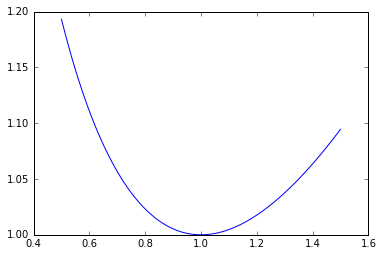

In [2]:
sig2 = 1.0  # likelihood variance : unfortunately does not seem to have much of an effect on psi here !

def hX(th):
    """ conditional entropy over X given \theta for likelihood (reminder: knowing this is cheating!) """
    return np.log(2*np.pi*sig2)/2

def dLpsi_dpsi( batch, phi, omega, psi, hX):
    """ assuming proposal p_\psi(\theta) to be Gaussian """
    
    """ written as *minimizing* the loss """
    
    th,x = batch
    mu = psi[0]
    sig2 = psi[1] **2   # std parametrization 
    
    N = x.shape[0]
    assert N == th.shape[0]    
    
    g = np.ones(2)    
    fac = lp_omega(x, omega) +  hX(th)
    
    g[0] = - (fac * (th-mu)/sig2).mean(axis=0)
    
    g[1] = 0.5/(sig2) * ( (fac * (1-(th-mu)**2/sig2)).mean()  - 1 ) 
    
    g[1] *= 2 * psi[1] # std parametrization 
    return g


phi = np.array([0.,0,1])
omega = np.array([0., 1.0])
psi = np.array([0., 1.])

print('omega \n', omega)

lr = 0.01
lr_decay = 0.99999
b1,b2,e=0.9, 0.99, 1e-8
m,v = np.zeros(2),np.ones(2)
batch_size = 100

#print(sig2)
for i in range(5000):    

    th = psi[0] + psi[1] * np.random.normal(size=batch_size)
    x  = th + np.sqrt(sig2)* np.random.normal(size=batch_size)
    batch = (th, x)
    
    if np.any(np.isnan(x)):
        break
    lr *= lr_decay
        
    g = dLpsi_dpsi( batch, phi, omega, psi, hX)
    lr *= lr_decay
    psi, m, v = adam_step(psi,g,m,v,lr,b1,b2,e,i+1)    
    
psi[1] = psi[1]**2
print('psi \n', psi)


# compare visually with result from viewing the whole thing as D_{KL} with p(x,th) = p_\omega(x) * N*(th),
# with N*(th) being a Gaussian with infinite variance:
# that one gives mu_\psi = mu_\omega, sig2_\psi/sig2_\omega = np.log(sig2_\psi * sig2), i.e. sig2_\psi = sig2_\omega!

sigs = np.linspace(omega[1]-.5,omega[1]+.5,100)

plt.plot(sigs,  sigs/omega[1]- np.log(sigs*sig2))
#plt.plot(sigs,  1/omega[1]- 1/sigs)
plt.show()


# full derivatives
- tbd

## d/d$\phi$
- checking with fixed large dataset

In [3]:
sig2 = 2.5  # likelihood variance : unfortunately does not seem to have much of an effect on psi here !

def hX(th):
    """ conditional entropy over X given \theta for likelihood (reminder: knowing this is cheating!) """
    return np.log(2*np.pi*sig2)/2

phi = np.array([0.0, 0.0, 1.])
omega = np.array([0.0, 1.0])
psi = np.array([0.4, 1.5])

print('omega \n', omega)

lr = 0.005
lr_decay = 1.0
b1,b2,e=0.9, 0.99, 1e-8
m,v = np.zeros(3),np.ones(3)

#print(sig2)

batch_size = 10000
th = psi[0] + psi[1] * np.random.normal(size=batch_size)
x  = th + np.sqrt(sig2)* np.random.normal(size=batch_size)
batch = (th, x)

for i in range(20000):    

    
    if np.any(np.isnan(x)):
        break
    lr *= lr_decay
        
    g = dL_dphi( batch, phi)        
    lr *= lr_decay
    phi, m, v = adam_step(phi,g,m,v,lr,b1,b2,e,i+1)    
    
print('phi \n', phi)
psi[1] = psi[1]**2

# analytic solution

a, b, = phi[0], phi[1]
print('analytic variance sol.:\n', (1-b)**2 * psi[1] + b**2 * sig2 + ( a + (b-1)*psi[0] )**2 )

omega 
 [ 0.  1.]
phi 
 [ 0.2146801   0.47686474  1.20188802]
analytic variance sol.:
 1.18428801748


## d/d$\omega$
- checking with fixed large dataset

In [4]:
sig2 = 1.  # likelihood variance : unfortunately does not seem to have much of an effect on psi here !

x0 = 0.8 
lambd = 1.

phi = np.array([0.0, 0.0, 1.])
omega = np.array([0.0, 1.0])
psi = np.array([0., 1.])

lr = 0.005
lr_decay = 1.0
b1,b2,e=0.9, 0.99, 1e-8
m,v = np.zeros(2),np.ones(2)

print('\lambda \n', lambd)
print('x0 \n', x0)

batch_size = 10000
th = psi[0] + psi[1] * np.random.normal(size=batch_size)
x  = th + np.sqrt(sig2)* np.random.normal(size=batch_size)
batch = (th, x)

for i in range(10000):    

    
    if np.any(np.isnan(x)):
        break
    lr *= lr_decay
        
    g = dL_domega( batch, x0, omega, lambd = lambd)       
    #g = dL_dpsi( batch, phi, omega, psi, hX)
    lr *= lr_decay
    omega, m, v = adam_step(omega,g,m,v,lr,b1,b2,e,i+1)    
    
print('omega \n', omega)


\lambda 
 1.0
x0 
 0.8
omega 
 [ 0.40209944  1.17168706]


## d/d$\psi$


In [28]:
sig2 = .5  # likelihood variance : unfortunately does not seem to have much of an effect on psi here !

phi = np.array([0., 0., 1.])
omega = np.array([0., 0.5])
psi = np.array([0., 1.])

print('omega \n', omega)
print('phi \n', phi)

lr = 0.01
lr_decay = 0.99999
b1,b2,e=0.9, 0.99, 1e-8
m,v = np.zeros(2),np.ones(2)
batch_size = 1000

#print(sig2)
for i in range(5000):    

    th = psi[0] + psi[1] * np.random.normal(size=batch_size)
    x  = th + np.sqrt(sig2)* np.random.normal(size=batch_size)
    batch = (th, x)
    
    if np.any(np.isnan(x)):
        break
    lr *= lr_decay
        
    g = dL_dpsi( batch, phi, omega, psi, hX)
    lr *= lr_decay
    psi, m, v = adam_step(psi,g,m,v,lr,b1,b2,e,i+1)    
    
psi[1] = psi[1]**2
print('psi \n', psi)

# compare with analytic solution to sigma^2_\psi under all-Gaussian setup
print('analytic variance sol.:\n', 1/((1 - phi[1] )**2 / phi[2] + 1/omega[1]))

omega 
 [ 0.   0.5]
phi 
 [ 0.  0.  1.]
psi 
 [ 0.02374835  0.3357965 ]
analytic variance sol.:
 0.333333333333


# putting it all together

In [11]:
x0 = 0.8 
lambd = 1.0
sig2 = 1.0   # likelihood variance : unfortunately does not seem to have much of an effect on psi here !
eta2 = 1.0   # real prior variance (for analytic division)

def hX(th):
    """ conditional entropy over X given \theta for likelihood (reminder: knowing this is cheating!) """
    return np.log(2*np.pi*sig2)/2

phi =   np.array([0.0, 0.0, 1.0])
omega = np.array([0.0, 2.0])
psi =   np.array([0.0, 1.0])
pars = pack_pars(phi, omega, psi)
print('pars \n', pars)

lr = 0.001
lr_decay = 1.0
b1,b2,e=0.9, 0.99, 1e-8
m,v = np.zeros(pars.size),np.ones(pars.size)
batch_size = 1000

#print(sig2)
for i in range(10000):    

    _, _, psi = unpack_pars(pars)    
    # draw from proposal
    th = psi[0] + psi[1] * np.random.normal(size=batch_size)
    # draw from simulator
    x  = th + np.sqrt(sig2)* np.random.normal(size=batch_size)
    
    if np.any(np.isnan(x)):
        break
    lr *= lr_decay
        
    g = grad( (th, x), pars, x0, hX, lambd)
    # selectively clamp parameters:
    #g[:3] *= 0   # clamp phi
    #g[3:-2] *= 0  # clamp omega
    #g[-1] *= 0   # clamp psi
    
    lr *= lr_decay
    pars, m, v = adam_step(pars,g,m,v,lr,b1,b2,e,i+1)    

phi, omega, psi = unpack_pars(pars)       
psi[1] = psi[1]**2
print('phi \n', phi)
print('omega \n', omega)
print('psi \n', psi)

post_ = np.array([phi[1] * x0 + phi[0], phi[2]])
post = analytic_div(post_.reshape(1,1,2), eta2, (psi[0],), (psi[1],))
print('est. post \n', post)

pars 
 [ 0.  0.  1.  0.  2.  0.  1.]
phi 
 [ 0.24138666  0.00225521  0.00291084]
omega 
 [ 0.28006076  0.64489477]
psi 
 [ 0.24141363  0.00292035]
est. post 
 [[[ 0.41563781  0.47198727]]]


In [ ]:


def grad( batch, pars, x0, hX, lambd=1):
    
    phi, omega, psi = unpack_pars(pars)
    
    g = np.hstack((dL_dphi( batch, phi), 
                   dL_domega( batch, x0, omega, lambd), 
                   dL_dpsi( batch, phi, omega, psi, hX) ))
    
    return g
    

# Wuehltisch.

In [ ]:
n_params = 1
pars = np.array([0.,0.,1., 0., 1., 0., 1.])

m = Gauss(dim=n_params, noise_cov=sig2)
p = dd.Gaussian(m=np.zeros(n_params), 
                S=np.eye(n_params))    
s = ds.Identity()
g_ = dg.Default(model=m, prior=p, summary=s)

lambd = 0.01
batch_size = 10

lr = 1e-2
lr_decay = 0.995
for i in range(1000):

    phi, omega, psi = unpack_pars(pars)
    g_.prior.m, g_.prior.S = psi[0], psi[1]
    batch = g_.gen(batch_size, verbose=False)    
    
    lr *= lr_decay    
    pars -= lr * grad( batch, pars, hX, lambd=lambd)
    #pars[-2], pars[-1] = 0, 1 

phi, omega, psi = unpack_pars(pars)
print('MDN phi \n', phi)
print('marginal omega \n', omega)
print('proposal psi \n', psi)

out = np.array([phi[0] + phi[1] * x0, phi[2]])
analytic_div(out.reshape(1,1,2), eta2, (psi[0],), (psi[1],))

In [ ]:
n_params = 1
pars = np.array([0.,0.,1., 0., 1., 0., 1.])

m = Gauss(dim=n_params, noise_cov=sig2)
p = dd.Gaussian(m=np.zeros(n_params), 
                S=np.eye(n_params))    
s = ds.Identity()
g_ = dg.Default(model=m, prior=p, summary=s)

lambd = 0.01

batch_size = 10
m, v = np.zeros_like(pars), np.ones_like(pars)

a=0.01 
b1=0.9
b2=0.99
e=1e-8
a_decay = 0.999

for i in range(5000):
        
    phi, omega, psi = unpack_pars(pars)
    g_.prior.m, g_.prior.S = psi[0], psi[1]
    batch = g_.gen(batch_size, verbose=False)
    
    g = grad( batch, pars, hX, lambd=lambd)
    a *= a_decay
    pars, m, v = adam_step(pars,g,m,v,a,b1,b2,e,i+1)
    
phi, omega, psi = unpack_pars(pars)
print(phi)
print(omega)
print(psi)

out = np.array([phi[0] + phi[1] * x0, phi[2]])
analytic_div(out.reshape(1,1,2), eta2, (psi[0],), (psi[1],))